In [427]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from datetime import datetime

### Structure
1. Load Data:
    - time range of 2 tables
    - user count of 2 tables
2. Data Clean:
    - categorize landing_page column of session table
    - categorize referral column of session table
    - transform time column and create date column of session table
    - categorize title column of page_view table
    - transform time column and create date column of session table
    - categorize landing_page column of page_view table
3. Comb 2 tables:
    - looks like session table only contains the first pageview of page_view table. Page_view table covers most of data from Session.
    - I decided to go only with page_view table(4days) 
4. Metrics:
    - Daily Active user
    - Product visitation Rate
    - Daily time spend
    - active product user & active product user rate
    - top 10 titles/actions users are doing with Measure Properties
    - retention rate
5. Summary & Next Steps

# Step 1: Load Data

In [449]:
session_all = pd.read_csv(r'./sessions_assignment_data.csv').drop('Unnamed: 0', axis = 1)
page_view = pd.read_csv(r'./page_view_assignment_data.csv').drop('Unnamed: 0', axis = 1)

In [450]:
print('The time range of session table is from ' + str(session_all.time.min()) + ' to ' + str(session_all.time.max()))
print('The time range of session table is from ' + str(page_view.time.min()) + ' to ' + str(page_view.time.max()))

The time range of session table is from 2018-12-01 00:00:23.689000 to 2019-01-14 23:59:58.996000
The time range of session table is from 2018-12-01 00:00:17.461000 to 2018-12-04 22:13:10.708000


In [451]:
# session uv
session_all.user_id.unique().__len__(), session_all.session_id.unique().__len__()

(45002, 96887)

In [645]:
# page_view uv
page_view.user_id.unique().__len__(), page_view.session_id.unique().__len__(), page_view.time.unique().__len__()

(4669, 7216, 61302)

### Finding 1:
- Session table 
    - from 2018/12/01 to 2019/01/14, __45 days__
    - __45K__ user_id and 97k session_id
    - 1 user_id - 1 session - 1 record
- Page view table
    - from 2018/12/01 to 2018/01/04, __4 days__
    - __4.7k__ user_id, 7.2k session_id
    - 1 user_id - 1 session - multi recoreds responding different pages

# Step 2: Data Cleaning
### Step 2.1: Session - Landing Page
- No missing
- categorize the 'landing_page' column into 'landing_page_cate'

In [454]:
session_all[session_all.landing_page.isnull()]

,user_id,session_id,time,library,platform,device_type,country,region,city,referrer,landing_page,browser


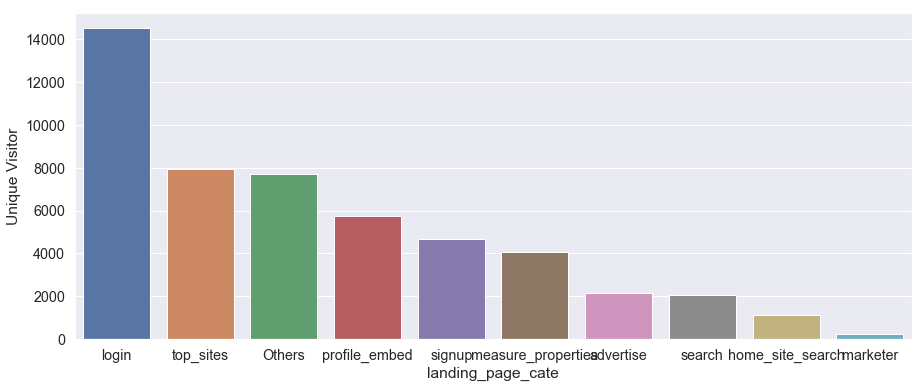

In [455]:
session_all.loc[session_all.landing_page.str.contains('user/login'), 'landing_page_cate'] = 'login'
session_all.loc[session_all.landing_page.str.contains('profile/embed'), 'landing_page_cate'] = 'profile_embed'
session_all.loc[session_all.landing_page.str.contains('top-sites'), 'landing_page_cate'] = 'top_sites'
session_all.loc[session_all.landing_page.str.contains('top-mobile-sites'), 'landing_page_cate'] = 'top_sites'
session_all.loc[session_all.landing_page.str.contains('/signup'), 'landing_page_cate'] = 'signup'
session_all.loc[session_all.landing_page.str.contains('/measure/'), 'landing_page_cate'] = 'measure_properties'
session_all.loc[session_all.landing_page.str.contains('/advertise'), 'landing_page_cate'] = 'advertise'
session_all.loc[session_all.landing_page.str.contains('quantcast.com/search'), 'landing_page_cate'] = 'search'
session_all.loc[session_all.landing_page.str.contains('quantcast.com/marketer'), 'landing_page_cate'] = 'marketer'
session_all.loc[session_all.landing_page.str.contains('quantcast.com/home/site/search/'), 'landing_page_cate'] = 'home_site_search'
session_all.loc[session_all.landing_page_cate.isnull(), 'landing_page_cate'] = 'Others'


landing_page_user_ct = session_all.groupby('landing_page_cate', 
                                           as_index=False).agg({'user_id':'nunique'}).sort_values('user_id', 
                                                                                              ascending = False)

# Visualization
fig, ax = plt.subplots(figsize = (15,6))
sns.barplot(x = 'landing_page_cate', y = 'user_id', data = landing_page_user_ct, ax = ax)
plt.ylabel('Unique Visitor')
plt.show()

### Step 2.2: Session - Referral
- Impute missing value as 'direct'
- regex 'referrer' into 'refer site'

In [456]:
session_all.loc[session_all.referrer.isnull(), 'referrer'] = 'direct'

def find_referrer(referrer):
    refer = re.search(r'https?://(www\.)?([\w-]+)[\.|/].*', referrer)
    if referrer == 'direct':
        return('direct')
    elif refer:
        return(refer.group(2))
    else:
        return('None')
session_all['refer_site'] = session_all.referrer.apply(lambda x: find_referrer(x))

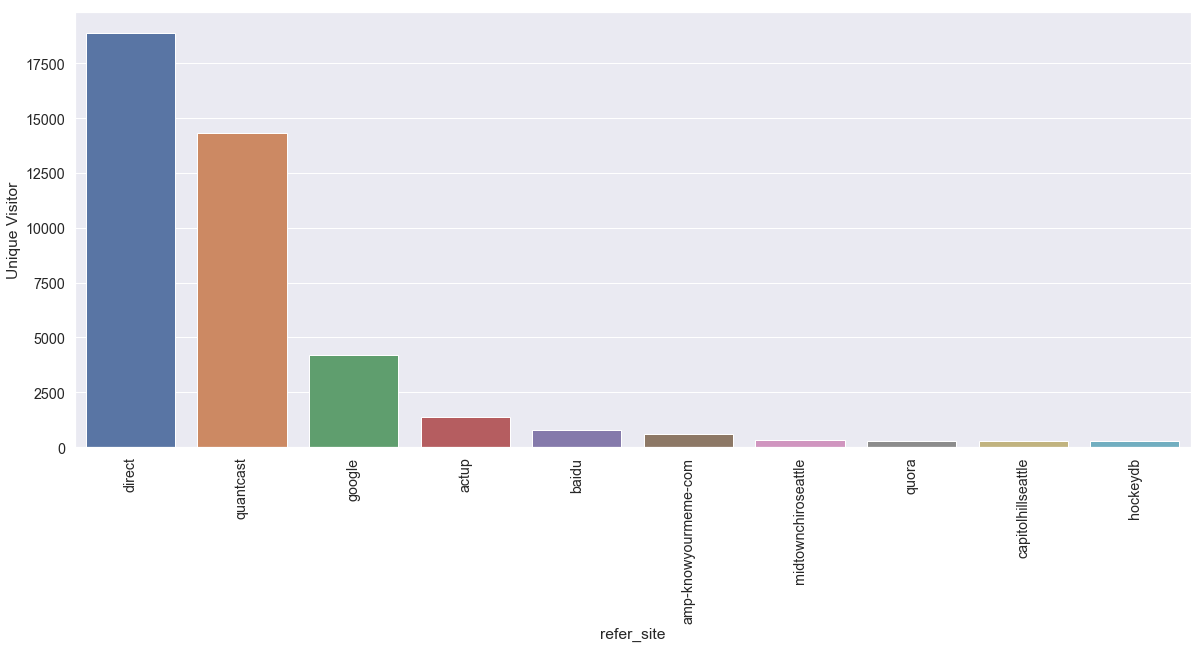

In [457]:
refer_site_user_ct = session_all.groupby('refer_site', 
                                         as_index=False).agg({'user_id':'nunique',
                                                              'session_id':'count'}).sort_values('user_id', ascending = False).head(10)

# Visualization
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize = (20,8))
sns.barplot(x = 'refer_site', y = 'user_id', data = refer_site_user_ct, ax = ax)
plt.ylabel('Unique Visitor')
plt.xticks(rotation=90)
plt.show()

### Step 2.3: Session - Time
- No missing
- Transform time from string to datetime

In [458]:
session_all['time'] = pd.to_datetime(session_all['time'], format='%Y%m%d %H:%M:%S.%f')
session_all['date'] = session_all.time.apply(lambda x:x.date())

#### Session 4 days
- We only pick up the first 4 days of session data in order to be lined up with page_view data

In [459]:
session = session_all[session_all.time < datetime(2018,12,5)]
session.user_id.unique().__len__(), session.session_id.__len__()

(5499, 9175)

In [460]:
session.time.min(), session.time.max()

(Timestamp('2018-12-01 00:00:23.689000'),
 Timestamp('2018-12-04 23:59:52.901000'))

### Step 2.4: Page View - Title

In [461]:
page_view[page_view.title.isna()]

,user_id,session_id,time,session_time,library,platform,device_type,country,region,city,referrer,landing_page,browser,domain,query,path,hash,title
61369,5460280904026299,6970734524813377,2018-12-04 11:48:36.329000,2018-12-04 11:48:36.329000,web,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [462]:
# page_view.groupby('landing_page', as_index = False).agg({'user_id':'nunique'}).sort_values('user_id', ascending = False).head(10)

In [463]:
page_view.loc[page_view.title.isnull(), 'title'] = 'None'
page_view['title_cate'] = page_view['title']

page_view.loc[page_view.title.str.contains('Audience Insights'), 'title_cate'] = 'Audience Insights'
page_view.loc[page_view.title.str.contains('Search Results'), 'title_cate'] = 'Search Results'
page_view.loc[page_view.title.str.contains('Ad Reporting'), 'title_cate'] = 'Ad Reporting'
page_view.loc[page_view.title.str.contains('Dashboard'), 'title_cate'] = 'Dashboard'
page_view.loc[page_view.title.str.contains('Creatives'), 'title_cate'] = 'Creatives'
page_view.loc[page_view.title.str.contains('Content Segments'), 'title_cate'] = 'Content Segments'
page_view.loc[page_view.title.str.contains('Advertise'), 'title_cate'] = 'Advertise'
page_view.loc[page_view.title.str.contains('Audience Measurement, Lookalike Modeling, Audience Buying'), 'title_cate'] = 'Audience Measurement, Lookalike Modeling, Audience Buying'
page_view.loc[page_view.title.str.contains('Top International Websites & Rankings'), 'title_cate'] = 'Top International Websites & Rankings'


title_cate_user_ct = page_view.groupby(
    'title_cate',as_index=False
).agg({'user_id':'nunique',
       'time':'count'}).sort_values('user_id', 
                                    ascending = False)
page_view.loc[page_view.title_cate.isin(title_cate_user_ct[title_cate_user_ct.user_id < 10]['title_cate']), 'title_cate'] = 'Others'

### Step 2.5: Page_view - Time
- No missing
- Transform time from string to datetime

In [467]:
page_view['time'] = page_view.time.apply(lambda x:dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f0'))
page_view['date'] = page_view.time.apply(lambda x:x.date())

### Step 2.6: Page_view - Landing Page
- impute the missing value with 'None'
- categorize the 'landing_page' column into 'landing_page_cate'

In [468]:
page_view[page_view.landing_page.isnull()]

,user_id,session_id,time,session_time,library,platform,device_type,country,region,city,referrer,landing_page,browser,domain,query,path,hash,title,title_cate,date
61369,5460280904026299,6970734524813377,2018-12-04 11:48:36.329,2018-12-04 11:48:36.329000,web,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Others,2018-12-04


In [469]:
page_view.loc[page_view.landing_page.isnull(), 'landing_page'] = 'None'
page_view.loc[page_view.landing_page.str.contains('user/login'), 'landing_page_cate'] = 'login'
page_view.loc[page_view.landing_page.str.contains('profile/embed'), 'landing_page_cate'] = 'profile_embed'
page_view.loc[page_view.landing_page.str.contains('top-sites'), 'landing_page_cate'] = 'top_sites'
page_view.loc[page_view.landing_page.str.contains('top-mobile-sites'), 'landing_page_cate'] = 'top_sites'
page_view.loc[page_view.landing_page.str.contains('/signup'), 'landing_page_cate'] = 'signup'
page_view.loc[page_view.landing_page.str.contains('/measure/'), 'landing_page_cate'] = 'measure_properties'
page_view.loc[page_view.landing_page.str.contains('/advertise'), 'landing_page_cate'] = 'advertise'
page_view.loc[page_view.landing_page.str.contains('quantcast.com/search'), 'landing_page_cate'] = 'search'
page_view.loc[page_view.landing_page.str.contains('quantcast.com/marketer'), 'landing_page_cate'] = 'marketer'
page_view.loc[page_view.landing_page.str.contains('quantcast.com/home/site/search/'), 'landing_page_cate'] = 'home_site_search'
page_view.loc[page_view.landing_page_cate.isnull(), 'landing_page_cate'] = 'Others'

# Step 3: Comb session and page view

- looks like session table only contains the first pageview of page_view table. Page_view table covers most of data from Session.
- I decided to go only with page_view table(4days) 

In [507]:
# dat = session[['session_id',
#                'user_id',
#                'refer_site',
#                'landing_page_cate',
#                'time']].merge(page_view[['user_id',
#                                          'session_id',
#                                          'time',
#                                          'date',
#                                          'landing_page',
#                                          'landing_page_cate',
#                                          'hash',
#                                          'title',
#                                          'title_cate']], 
#                               how = 'inner', 
#                               on = ['user_id', 'session_id'],
#                              suffixes = ('_start', '_pv'))

dat = page_view[['user_id',
                 'session_id',
                 'time','date',
                 'landing_page',
                 'landing_page_cate',
                 'hash',
                 'title',
                 'title_cate']]

# Step 4: Metrics

### Overview:

|Category|User Status|Conv %|
|-|-|-|
|Acquisition|Visit Quantcast.com|100%|
|Acquisition|Use Measure Properties|14%|
|segmentation|returning Vs new users(Measure Properties)|13.8% vs <0.5%|
|Activation|Visit 3 types of page title or click 15+ pages when using Measure Properties|2.6%|
|Retention|Used Measure Properties 3 days in a month| 10%|

#### Findings:
- This funnel analysis is only based on 4 days data(12/1 - 12/4), since we only have 4-days page_view. It would be better if we have at lest 1 week data.
- 14% of Quantcast visitors use the Measure Properties product.
Less than 3%(0.5%/14%) product users are new. It seems we have trouble attracting new users to Measure Properties
- 2.6% product users are very active
- The retention rate is 10%, which is not bad. 

### Step 4.1: Daily Active Users(visit at least 1 page)
#### Findings:
- Weekend(12/01, 12/02) shows lower numbers. Weekday(12/3) shows higher numbers. 
- The difference between 12/3 and 12/4 is due to missing data for 12/4

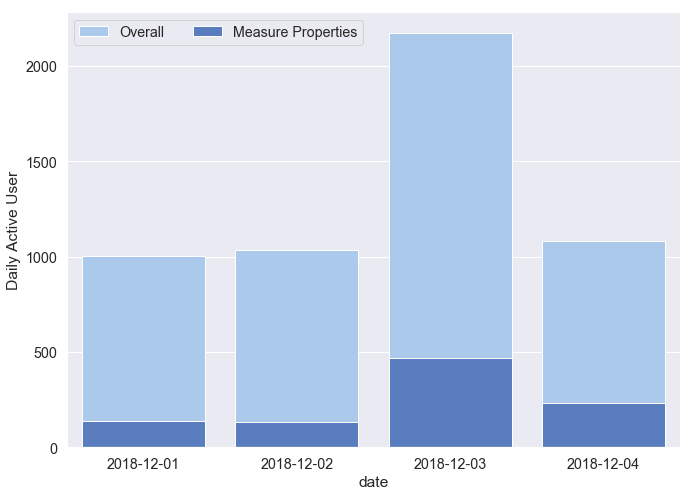

In [644]:
# site daily active users
site_dau_ct = dat.groupby('date', as_index = False).agg({'user_id':'nunique'})

# Measure Properties daily active users
product_user = dat[dat.user_id.isin(dat[dat.landing_page_cate == 'measure_properties'].user_id.unique())]
product_dau_ct = product_user.groupby('date', as_index = False).agg({'user_id':'nunique'})

# Visulization
fig, ax = plt.subplots(figsize = (11,8))
# site_user = session.groupby('date', as_index = False).agg({'user_id':'nunique'})
sns.set_color_codes("pastel")
sns.barplot(x="date", y="user_id", data= site_dau_ct,label="Overall", color="b", ax = ax)

sns.set_color_codes("muted")
sns.barplot(x = 'date', y = 'user_id', data = product_dau_ct, label="Measure Properties", color="b", ax = ax)
plt.ylabel('Daily Active User')

ax.legend(ncol=2, loc="upper left", frameon=True)
plt.show()

### Step 4.2: Product visitation rate(Measure Properties)

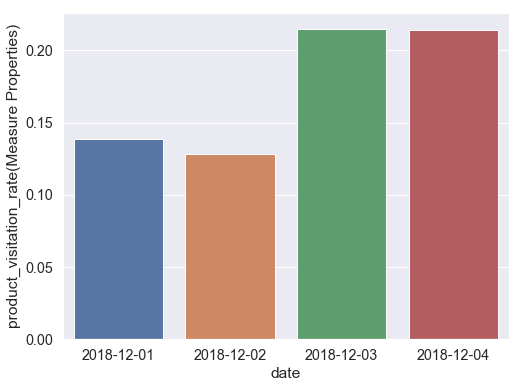

In [575]:
product_visitation_rate = site_dau_ct.merge(product_dau_ct, how = 'inner', on = 'date', suffixes=('_site', '_pro'))
product_visitation_rate['product_visitation_rate(Measure Properties)'] = product_visitation_rate['user_id_pro']/product_visitation_rate['user_id_site']

# Visualization
fig, ax = plt.subplots(figsize = (8,6))
sns.barplot(x = 'date', y = 'product_visitation_rate(Measure Properties)', data = product_visitation_rate, ax = ax)
plt.show()

In [615]:
print('Product Visitation Rate overall: ' + 
      str(100*round(product_user.user_id.unique().__len__()/dat.user_id.unique().__len__(), 2)) +
      '%')

Product Visitation Rate overall: 14.000000000000002%


### Step 4.3: Daily Timespend
#### Findings:
- Blue bars show the daily time spend for Quantcast visitors 
- Orange bars show the daily time spend on Measure Properties for Measure Properties users.
- Product is attracting people to spend more time on it, which means product is good. As long as people sign up and sign in to be a product user, they spend much more time than others.
- Weekend(12/01, 12/02) shows lower numbers. Weekday(12/3) shows higher numbers.  

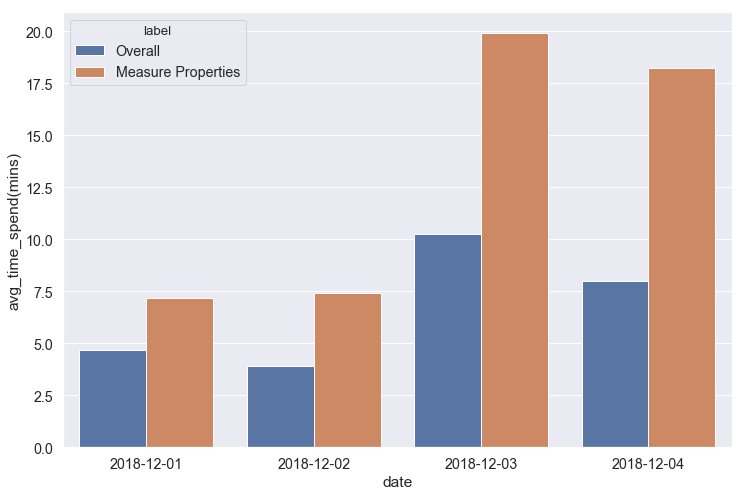

In [614]:
# site overall time spend
start_end_site = dat.groupby(['date','user_id', 'session_id'], as_index = False).agg({'time':['max', 'min']})
start_end_site.columns =['date','user_id', 'session_id', 'max', 'min']                    
start_end_site['time_spend'] = start_end_site['max'] - start_end_site['min']
start_end_site['time_spend'] = start_end_site.time_spend.apply(lambda x:x.total_seconds()/60)
time_spend_site = start_end_site.groupby('date', as_index=False).agg({'user_id': 'nunique','time_spend':'sum'})
time_spend_site['avg_time_spend(mins)'] = time_spend_site['time_spend']/time_spend_site['user_id']
time_spend_site['label'] = 'Overall'


# Product time spend
start_end_product = product_user.groupby(['date','user_id', 'session_id'], as_index = False).agg({'time':['max', 'min']})
start_end_product.columns =['date','user_id', 'session_id', 'max', 'min']                    
start_end_product['time_spend'] = start_end_product['max'] - start_end_product['min']
start_end_product['time_spend'] = start_end_product.time_spend.apply(lambda x:x.total_seconds()/60)
time_spend_product = start_end_product.groupby('date', as_index=False).agg({'user_id': 'nunique','time_spend':'sum'})
time_spend_product['avg_time_spend(mins)'] = time_spend_product['time_spend']/time_spend_product['user_id']
time_spend_product['label'] = 'Measure Properties'


time_spend = pd.concat([time_spend_site, time_spend_product])

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='date', y='avg_time_spend(mins)', hue='label', data=time_spend, ax=ax)
plt.show()

### Step 4.4: New vs Returning users - Measure Properties
- New user: users who did sign up before using Measure Properites
- Returning usres: users who used Measure Properties without sign-up
#### Findings:
- From previous metric, we know that our product is good in terms of time spend. 
- But from proportion of New vs returning users Graph, we can say we have got some problem attracting new users.
- Weekend(12/01, 12/02) shows lower numbers. Weekday(12/3) shows higher numbers.  

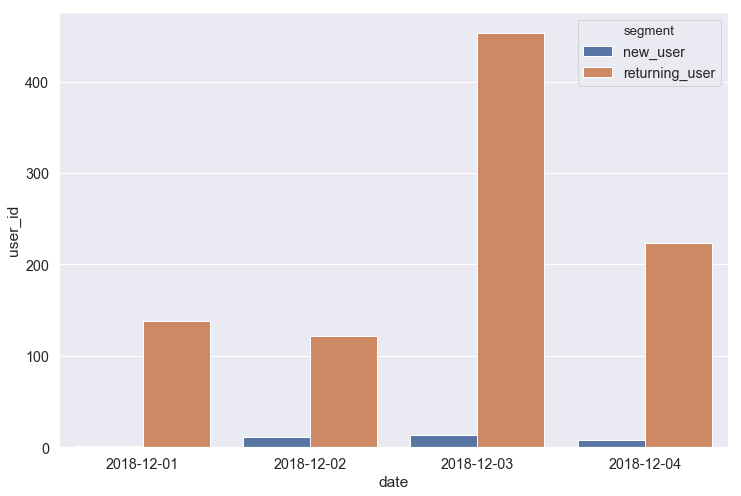

In [647]:
# new users: product users who signed up in these 4 days
product_user.loc[product_user.user_id.isin(product_user[product_user.landing_page_cate == 'signup'].user_id),
                'segment'] = 'new_user'
# returning users: Others
product_user.loc[product_user.segment.isnull(), 'segment'] = 'returning_user'

user_segment = product_user.groupby(['date', 'segment'], as_index = False).agg({'user_id':'nunique'})

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='date', y='user_id', hue='segment', data= user_segment, ax=ax)
plt.show()

In [648]:
# New vs Returning users out of Measure Properties Users
print('new user:' + 
      str(100*product_user[product_user.segment == 'new_user'].user_id.unique().__len__()/product_user.user_id.unique().__len__()) +
     '%')
print('returning user:' + 
      str(100*product_user[product_user.segment == 'returning_user'].user_id.unique().__len__()/product_user.user_id.unique().__len__()) +
     '%')

new user:2.848575712143928%
returning user:97.15142428785607%


In [649]:
# New vs Returning users out of all Quantcast Visitors
print('new user:' + 
      str(100*product_user[product_user.segment == 'new_user'].user_id.unique().__len__()/dat.user_id.unique().__len__()) +
     '%')
print('returning user:' + 
      str(100*product_user[product_user.segment == 'returning_user'].user_id.unique().__len__()/dat.user_id.unique().__len__()) +
     '%')

new user:0.40693938744913255%
returning user:13.878774898265153%


### Step 4.5 Active Users(Measure Properties) - visit 3+ types of titles or 20+ pages when use measure properties 
#### Findings:
- Weekend(12/01, 12/02) shows lower numbers. Weekday(12/3) shows higher numbers.

In [576]:
# Active user type1: visit 3+ types of titles when use measure properties 
action_types_ct = product_user[product_user.landing_page_cate == 'measure_properties'].groupby(
    ['date','user_id'], as_index = False).agg({'title_cate':'nunique'})
active_product_user1 = action_types_ct[action_types_ct.title_cate >=3]

# Active user type2: visit 20+ pages when use measure properties 
page_view_ct =  product_user[product_user.landing_page_cate == 'measure_properties'].groupby(
    ['date','user_id'], as_index = False).agg({'time':'count'})
active_product_user2 = page_view_ct[page_view_ct.time > 15]

active_product_user = product_user[(product_user.user_id.isin(active_product_user1.user_id)) &
                                  (product_user.user_id.isin(active_product_user2.user_id))]

active_user_ct = active_product_user.groupby('date', as_index = False).agg({'user_id':'nunique'})

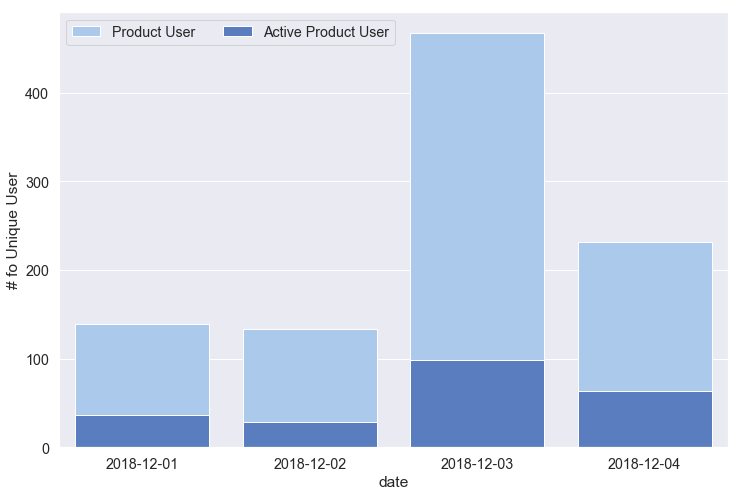

In [577]:
# Visulization
fig, ax = plt.subplots(figsize = (12,8))
sns.set_color_codes("pastel")
sns.barplot(x="date", y="user_id", data= product_dau_ct,label="Product User", color="b", ax = ax)

sns.set_color_codes("muted")
sns.barplot(x = 'date', y = 'user_id', data = active_user_ct, label="Active Product User", color="b", ax = ax)
plt.ylabel('# fo Unique User')

ax.legend(ncol=2, loc="upper left", frameon=True)
plt.show()

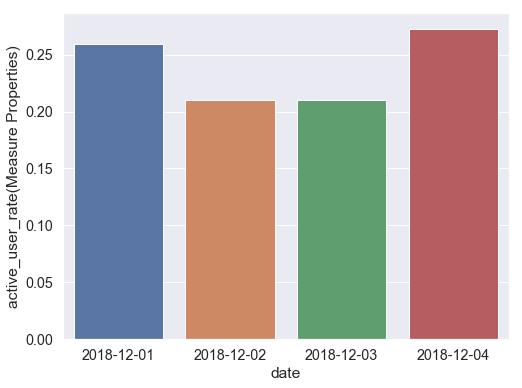

In [583]:
active_user_rate = active_user_ct.merge(product_dau_ct, how = 'inner', on = 'date', suffixes=('_active', '_pro'))
active_user_rate['active_user_rate(Measure Properties)'] = active_user_rate['user_id_active']/active_user_rate['user_id_pro']

# Visualization
fig, ax = plt.subplots(figsize = (8,6))
sns.barplot(x = 'date', y = 'active_user_rate(Measure Properties)', data = active_user_rate, ax = ax)
plt.show()

In [633]:
print('active user:' + 
      str(100*active_product_user.user_id.unique().__len__()/dat.user_id.unique().__len__()) +
     '%')

active user:2.591561362176055%


### Step 4.6: Top 10 title/action users do with Measure Properties

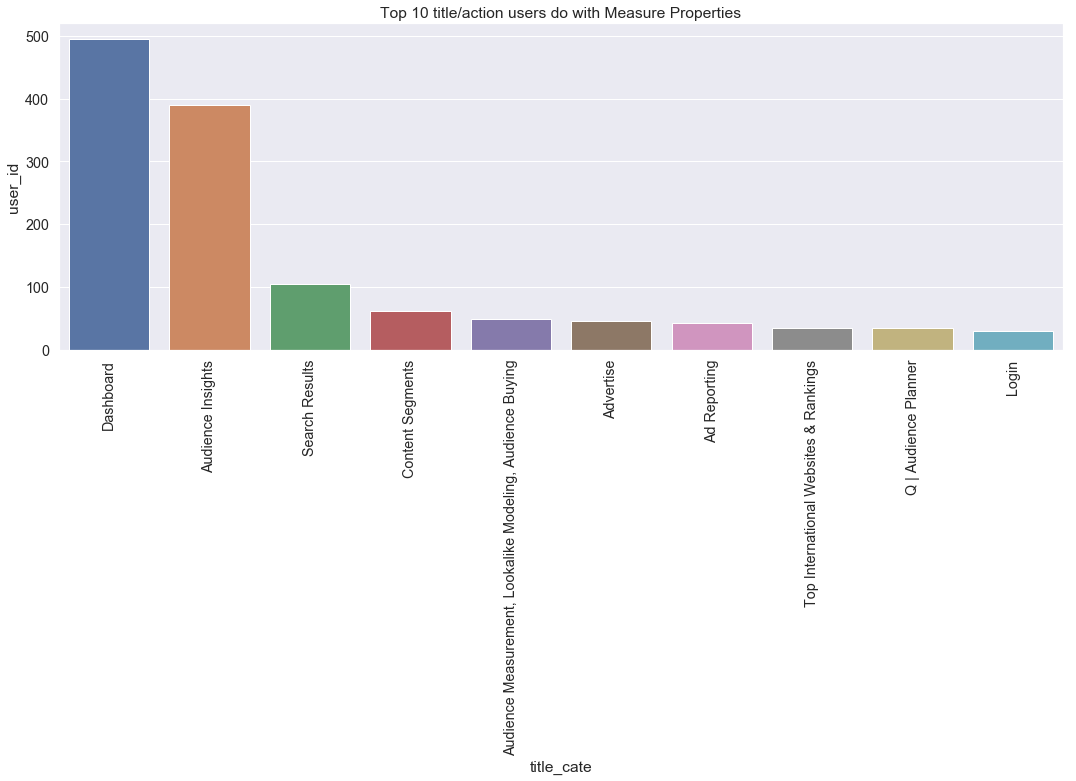

In [584]:
top10_title = product_user[product_user.landing_page_cate == 'measure_properties'].groupby(
    'title_cate', as_index = False
).agg({'user_id':'nunique'}).sort_values('user_id', ascending = False).head(10)

# Visualization
fig, ax = plt.subplots(figsize = (18,6))
sns.barplot(x='title_cate', y = 'user_id', data = top10_title, ax = ax)
ax.set_title('Top 10 title/action users do with Measure Properties')
plt.xticks(rotation=90)
plt.show()

### Step 4.7: Retention rate

In [641]:
active_days = session_all[(session_all.user_id.isin(product_user.user_id)) &
                          (session_all.landing_page_cate == 'measure_properties') &
                          (session_all['time'] < datetime(2019,1,5))].groupby('user_id', 
                                                                               as_index = False).agg({'date':'nunique'})



In [642]:
print('retention_rate:' + 
      str(100*active_days[active_days.date >= 2].user_id.unique().__len__()/dat.user_id.unique().__len__()) +
     '%')

retention_rate:9.916470336260442%


# Step 5: summary and next step

### Summary
1.  It seems the product Measure Properties is doing good job on user experience	:
    - 300+ daily users
    - 100+ active users
    - 10% retention rate
    - 15+ mins time spend 
2. But we have trouble attracting new users: only 3% of our product users are new.
3. Recommendation:  
    - Check the new users source: find out the channels/referred sites with most new users and post ads(The available data size is too small, only 19 new users total, which was not feasible for this question)
    - Show ads on Quantcast to the returning users, since we have relatively low(14%) proportion of Quantcast visitors finally use the Measure Properties.

### Next Steps:
- At least 1 week page_view data to analyze the trends and get more accurate results for the metrics.
- Measure Properties users conversion data(contact sales/purchase/download reports) to analyze the conversion rate.
- 1 month of new users data: find out what channels are most of new users from and where they get stack to explore more product on Quantcast